In [82]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import csv

## Loading data

In [159]:
#load the data 
def load_csv_data(data_path, sub_sample=False):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    ids = x[:, 0].astype(np.int)
    input_data = x[:, 2:]

    yb = np.ones(len(y))
    yb[np.where(y == "b")] = -1

    # sub-sample
    if sub_sample:
        yb = yb[::50]
        input_data = input_data[::50]
        ids = ids[::50]

    return yb, input_data, ids

##############################

#standardize the data
def standardize(x):

    mean_x = np.mean(x)
    x = x - mean_x
    std_x = np.std(x)
    x = x / std_x
    return x, mean_x, std_x

##############################

#extract each feature of x
def extract(lst, nb):
    return [item[nb] for item in lst]

##############################

#create subplot for each feature
def subplot(y,x,n):
    feat = x[:,n] #extract(x,n)
    ax.plot(feat,y,'o')
    ax.set_title(f'Feature '+ str(n))
    
##############################

#compute the number of undefined values in a certain feature
def nb_undef_feat(x, n):
    feat = x[:,n] #extract(x,n)
    unique, frequency = np.unique(feat, return_counts = True) #ligne à changer
    
    if(unique[0] == -999): 
        return int(frequency[0]) 
    else: 
        return 0
    
##############################

#remove a column from the data
def remove_feat(x, n):
    d = np.delete(d,n, axis = 1)
    return d

##############################

#remove a feature from a data set that has more than 
#only put x as argument
def remove_feat_w_undef(x):
    xdel = []
    #xinter= x[0]
    for i in range(len(x[0])):
        nb = nb_undef_feat(x, i)
        if(nb > np.double(0.6*len(x))):
            xdel = xdel + [i]
        elif(nb > 0):
            taille = len(x[:, i])
            if(taille % 2 == 0):
                index1 = int((taille + nb)/2 - 0.5)
                index2 = int((taille + nb)/2 + 0.5)
                x_sorted = np.sort(x[:, i])
                xmedian = (x_sorted[index1] + x_sorted[index2]) / 2.0
            else:
                index = int((taille + nb)/2)
                xmedian = (np.sort(x[:, i]))[index]

            x[:,i][x[:,i] == -999] = xmedian
 
    x = np.delete(x,xdel,axis =1)
    return x, xdel
       
##############################

def Multi_Model(tx):
#change so that we also keep the indices
    tx0 = []
    tx1 = []
    tx2 = []
    tx3 = []
    index0 = []
    index1 = []
    index2 = []
    index3 = []
    
    for i in range(len(tx)):
        if(tx[i][22]==0):
            tx0 = tx0 + [tx[i]]
            index0 = index0 + [i]
        else:
            if(tx[i][22]==1):
                tx1 = tx1 + [tx[i]]
                index1 = index1 + [i]
            else:
                if(tx[i][22]==2):
                    tx2 = tx2 + [tx[i]]
                    index2 = index2 + [i]
                else:
                    if(tx[i][22]==3):
                        tx3 = tx3 + [tx[i]]
                        index3 = index3 + [i]
    
    return np.array(tx0), np.array(tx1), np.array(tx2), np.array(tx3), index0, index1, index2, index3

##############################
              
#create a csv submission
def create_csv_submission(ids, y_pred, name):

    with open(name, "w") as csvfile:
        fieldnames = ["Id", "Prediction"]
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({"Id": int(r1), "Prediction": int(r2)})
            
######################################
def build_model_data(height, weight):   
    
    y = weight
    x = height
    num_samples = len(y)
    tx = np.c_[np.ones(num_samples), x]
    return y, tx
######################################
#Cross-validation implementation
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.
    
    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)
##########################################
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x),1)) #careful ! 
    for deg in range(1,degree+1) :
        poly = np.c_[poly, np.power(x,deg)]
    return poly
##########################################
def id_outliers(x):
    for i in range(len(x[0])):
        m = np.mean(x[:,i])
        std = np.std(x[:,i])
        nb = nb_undef_feat(x, i)
        
        taille = len(x[:, i])
        if(taille % 2 == 0):
            index1 = int((taille + nb)/2 - 0.5)
            index2 = int((taille + nb)/2 + 0.5)
            x_sorted = np.sort(x[:, i])
            xmedian = (x_sorted[index1] + x_sorted[index2]) / 2.0
        else:
            index = int((taille + nb)/2)
            xmedian = (np.sort(x[:, i]))[index]
             
        print(len(x[x[:,i] > m + 2*std]))
        print(len(x[x[:,i] < m - 2*std]))
        x[x[:,i] > m + 3*std] = xmedian
        x[x[:,i] < m - 3*std] = xmedian
        
        return x

In [98]:
#add more useful features => convert angles in x and y axis [to do after the splitting of classes (+cleaning)?]
#to be converted : PRI_tau_phi [15], PRI_lep_phi [18], PRI_met_phi[20], PRI_jet_leading_phi [25] (NDA if 0),PRI_jet_subleading_phi [28] (NDA if 0/1) 
def to_carthesian(phi):
    x = np.cos(phi)
    y = np.sin(phi)
    
    return x,y


#This data must be used with the already DIVIDED DATA, but not cleaned
def data_to_carthesian(data):
    if(data[1][22]==0):
        #PRI_tau_phi 
        colA, colB = to_carthesian(data[:,15])
        colModA = np.array([colA]).T
        colModB = np.array([colB]).T
        data = np.append(data,colModA, axis = 1)
        data = np.append(data,colModB, axis = 1)
        #PRI_lep_phi
        colA, colB = to_carthesian(data[:,18])
        colModA = np.array([colA]).T
        colModB = np.array([colB]).T
        data = np.append(data,colModA, axis = 1)
        data = np.append(data,colModB, axis = 1)
        #PRI_met_phi
        colA, colB = to_carthesian(data[:,20])
        colModA = np.array([colA]).T
        colModB = np.array([colB]).T
        data = np.append(data,colModA, axis = 1)
        data = np.append(data,colModB, axis = 1)
        #data.append(to_carthesian(data[:,11]),to_carthesian(data[:,14]),to_carthesian(data[:,16]))
        toDelete = [15,18,20]
        data = np.delete(data, toDelete, axis=1)
        return data
        
    #offsetting of four after cleaning
    elif(data[1][22]==1):
        #PRI_tau_phi 
        colA, colB = to_carthesian(data[:,15])
        colModA = np.array([colA]).T
        colModB = np.array([colB]).T
        data = np.append(data,colModA, axis = 1)
        data = np.append(data,colModB, axis = 1)
        #PRI_lep_phi
        colA, colB = to_carthesian(data[:,18])
        colModA = np.array([colA]).T
        colModB = np.array([colB]).T
        data = np.append(data,colModA, axis = 1)
        data = np.append(data,colModB, axis = 1)
        #PRI_met_phi
        colA, colB = to_carthesian(data[:,20])
        colModA = np.array([colA]).T
        colModB = np.array([colB]).T
        data = np.append(data,colModA, axis = 1)
        data = np.append(data,colModB, axis = 1)
        #PRI_jet_leading_phi
        colA, colB = to_carthesian(data[:,25])
        colModA = np.array([colA]).T
        colModB = np.array([colB]).T
        data = np.append(data,colModA, axis = 1)
        data = np.append(data,colModB, axis = 1)
        #data.append(to_carthesian(data[:,11]),to_carthesian(data[:,14]),to_carthesian(data[:,16]), to_carthesian(data[:,21]))
        toDelete = [15,18,20,25]
        data = np.delete(data, toDelete, axis=1)
        return data
    elif(data[1][22]==2 or data[1][22]==3):
        #PRI_tau_phi 
        colA, colB = to_carthesian(data[:,15])
        colModA = np.array([colA]).T
        colModB = np.array([colB]).T
        data = np.append(data,colModA, axis = 1)
        data = np.append(data,colModB, axis = 1)
        #PRI_lep_phi
        colA, colB = to_carthesian(data[:,18])
        colModA = np.array([colA]).T
        colModB = np.array([colB]).T
        data = np.append(data,colModA, axis = 1)
        data = np.append(data,colModB, axis = 1)
        #PRI_met_phi
        colA, colB = to_carthesian(data[:,20])
        colModA = np.array([colA]).T
        colModB = np.array([colB]).T
        data = np.append(data,colModA, axis = 1)
        data = np.append(data,colModB, axis = 1)
        #PRI_jet_leading_phi
        colA, colB = to_carthesian(data[:,25])
        colModA = np.array([colA]).T
        colModB = np.array([colB]).T
        data = np.append(data,colModA, axis = 1)
        data = np.append(data,colModB, axis = 1)
        #PRI_jet_subleading_phi
        colA, colB = to_carthesian(data[:,28])
        colModA = np.array([colA]).T
        colModB = np.array([colB]).T
        data = np.append(data,colModA, axis = 1)
        data = np.append(data,colModB, axis = 1)
        #data.append(to_carthesian(data[:,15]),to_carthesian(data[:,18]),to_carthesian(data[:,20]), to_carthesian(data[:,25]), to_carthesian(data[:,28]))
        toDelete = [15,18,20,25,28]
        data = np.delete(data, toDelete, axis=1)
        return data
    else:
        print("ERROR: there's a mistake in your indexes, darling")

In [85]:
train_data = load_csv_data('train.csv', sub_sample=False)
test_data = load_csv_data('test.csv', sub_sample=False)

/tmp/ipykernel_109715/167336792.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ids = x[:, 0].astype(np.int)


In [86]:
type(train_data)
len(train_data)
print(train_data)

(array([ 1., -1., -1., ...,  1., -1., -1.]), array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ...,
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]]), array([100000, 100001, 100002, ..., 349997, 349998, 349999]))


In [87]:
y = train_data[0]

In [88]:
train_data[1]

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ...,
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]])

In [89]:
train_data[2]

array([100000, 100001, 100002, ..., 349997, 349998, 349999])

In [90]:
#train_data[4] is out of range
train_data[1][1]
len(train_data[1][1])

30

In [91]:
len(train_data[1])

250000

In [92]:
train_data_std = train_data
# 1st column is 'y'
# 2nd column is 'X'
# 3rd column is 'ids'

In [93]:
train_data_std1, mean1, std1 = standardize(train_data[1]) #see to what it corresponds
#train_data_std2, mean2, std2 = standardize(train_data[2]) #see to what it corresponds

In [94]:
def get_with_index(x, idx):
    x_fin = []
    
    for i in range(len(idx)):
        x_fin += [x[idx[i]]]
    
    return np.array(x_fin)

def create_with_index(x0, x1, x2, x3, idx0, idx1, idx2, idx3):
    total_length = len(x0) + len(x1) + len(x2) + len(x3)
    x_fin = np.repeat(x0[0], total_length).reshape(total_length,)
    
    print(x0.shape)
    print(len(idx0))
    print(x_fin.shape)
    
    for i in range(len(x0)):
        x_fin[idx0[i]] = x0[i]
    for i in range(len(x1)):
        x_fin[idx1[i]] = x1[i]
    for i in range(len(x2)):
        x_fin[idx2[i]] = x2[i]
    for i in range(len(x3)):
        x_fin[idx3[i]] = x3[i]
        
    return x_fin

In [95]:
"""
zero, un, deux, trois, idx0, idx1, idx2, idx3 = Multi_Model(train_data[1])
x_fin = create_with_index(zero, un, deux, trois, idx0, idx1, idx2, idx3)

test = True

for i in range(len(x_fin)):
    for j in range(len(x_fin[0])):
        if(x_fin[i,j] != np.array(train_data[1])[i,j]):
            print(i)
            test = False
            break
        
print(test)
"""

'\nzero, un, deux, trois, idx0, idx1, idx2, idx3 = Multi_Model(train_data[1])\nx_fin = create_with_index(zero, un, deux, trois, idx0, idx1, idx2, idx3)\n\ntest = True\n\nfor i in range(len(x_fin)):\n    for j in range(len(x_fin[0])):\n        if(x_fin[i,j] != np.array(train_data[1])[i,j]):\n            print(i)\n            test = False\n            break\n        \nprint(test)\n'

## Removing columns with too many undefined the train data

In [160]:
#load data : already done
####

#separate the data in 4 according to feature index 22
zero, un, deux, trois, idx0, idx1, idx2, idx3 = Multi_Model(train_data[1])
print(train_data[1].shape)

y0 = get_with_index(y, idx0)
y1 = get_with_index(y, idx1)
y2 = get_with_index(y, idx2)
y3 = get_with_index(y, idx3)

zero = data_to_carthesian(zero)
un = data_to_carthesian(un)
deux = data_to_carthesian(deux)
trois = data_to_carthesian(trois)

#drop columns in each of the four subdivisions if they have columns with more than 60% of undefined data
zero_new, xdel0 = remove_feat_w_undef(zero)
print(zero_new.shape)
un_new, xdel1 = remove_feat_w_undef(un)
print(un_new)
deux_new, xdel2 = remove_feat_w_undef(deux)
print(deux_new)
trois_new, xdel3 = remove_feat_w_undef(trois)
print(trois_new)

print("inside")
#for each subdivision : see correlation plots
zero_new = id_outliers(zero_new)
un_new = id_outliers(un_new)
deux_new = id_outliers(deux_new)
trois_new = id_outliers(trois_new)
#for each column of each subdivision print the percent of -999 present 


#standardize the cleaned data
zero_std, _, _ = standardize(zero_new)
print(zero_std)
un_std, _, _ = standardize(un_new)
print(un_std)
deux_std, _, _ = standardize(deux_new)
print(deux_std)
trois_std, _, _ = standardize(trois_new)
print(trois_std.shape)

#drop columns with little correlation



(250000, 30)
(99913, 23)
[[ 1.60937000e+02  6.87680000e+01  1.03235000e+02 ... -9.41006551e-01
   4.01172336e-01  9.16002597e-01]
 [ 1.12405500e+02  1.62172000e+02  1.25953000e+02 ... -8.16655919e-01
  -4.41440719e-01 -8.97290417e-01]
 [ 1.54916000e+02  1.04180000e+01  9.47140000e+01 ... -9.81965749e-01
  -1.52605060e-01 -9.88287254e-01]
 ...
 [ 1.12405500e+02  7.82560000e+01  7.96990000e+01 ...  9.74616132e-01
   7.60963137e-01 -6.48795117e-01]
 [ 1.33457000e+02  7.75400000e+01  8.89890000e+01 ... -8.78636927e-01
  -8.13533961e-01  5.81517406e-01]
 [ 1.05457000e+02  6.05260000e+01  7.58390000e+01 ... -2.48946787e-01
   9.86253610e-01 -1.65238667e-01]]
[[ 1.38470000e+02  5.16550000e+01  9.78270000e+01 ...  4.29555055e-01
  -7.85933026e-01 -6.18311635e-01]
 [ 1.48754000e+02  2.88620000e+01  1.07782000e+02 ...  9.92712991e-01
  -9.30656745e-01 -3.65893460e-01]
 [ 1.41481000e+02  7.36000000e-01  1.11581000e+02 ...  9.88042953e-01
  -9.37091709e-01 -3.49083270e-01]
 ...
 [ 1.19934000e+02  

In [161]:
import implementations

tx0 = build_poly(zero_std, 3)
tx1 = build_poly(un_std, 3)
tx2 = build_poly(deux_std, 3)
tx3 = build_poly(trois_std, 3)

#tx0 = np.delete(tx0, [1,3,4,6,11,12,14,15,17,19,20], axis = 1)
#tx1 = np.delete(tx1, [1,3,5,6,11,12,13,14,15,16,17,19,21,22], axis = 1)
#tx2 = np.delete(tx2, [1,3,8,15,16,17,18,19,21,22,23,25,26,28,29], axis = 1)
#tx3 = np.delete(tx3, [1,3,8,9,10,15,16,17,18,19,21,22,23,24,25,26,27,28,29,30], axis = 1)

print(tx0.shape)
print(tx1.shape)
print(tx2.shape)
print(tx3.shape)

#_, tc = build_model_data(test_data[1], test_data[1])

y0_bis = (y0 + 1)/2
y1_bis = (y1 + 1)/2
y2_bis = (y2 + 1)/2
y3_bis = (y3 + 1)/2

(99913, 70)
(77544, 82)
(50379, 106)
(22164, 106)


In [138]:
#d'apres le graph 0: 2,5,7,8,9,10,14,15
#d'apres le graph 1: 2,4,7,8,9,10,15,16,18
#d'apres le graph 2: 2,4,5,6,7,9,10,11,12,13,14,21,23,25
#d'apres le graph 3: 2,4,5,6,7,11,12,13,14,18

In [139]:
t0, t1, t2, t3, idx0, idx1, idx2, idx3 = Multi_Model(test_data[1])

t0 = data_to_carthesian(t0)
t1 = data_to_carthesian(t1)
t2 = data_to_carthesian(t2)
t3 = data_to_carthesian(t3)

t0_cleaned = np.delete(t0, xdel0, axis = 1)
t1_cleaned = np.delete(t1, xdel1, axis = 1)
t2_cleaned = np.delete(t2, xdel2, axis = 1)
t3_cleaned = np.delete(t3, xdel3, axis = 1)

t0_cleaned = build_poly(t0_cleaned, 1)
t1_cleaned = build_poly(t1_cleaned, 1)
t2_cleaned = build_poly(t2_cleaned, 1)
t3_cleaned = build_poly(t3_cleaned, 1)

#t0_cleaned = np.delete(t0_cleaned, [1,3,4,6,11,12,14,15,17,19,20], axis = 1)
#t1_cleaned = np.delete(t1_cleaned, [1,3,5,6,11,12,13,14,15,16,17,19,21,22], axis = 1)
#t2_cleaned = np.delete(t2_cleaned, [1,3,8,15,16,17,18,19,21,22,23,25,26,28,29], axis = 1)
#t3_cleaned = np.delete(t3_cleaned, [1,3,8,9,10,15,16,17,18,19,21,22,23,24,25,26,27,28,29,30], axis = 1)

In [127]:
print(tx0[-5:])

[[ 1.00000000e+00  2.33217769e+00  1.30167760e+00  1.69499457e+00
  -5.78033237e-01 -5.24166760e-01 -5.78033237e-01  1.03715881e+00
  -5.44521412e-01 -6.28025912e-01 -1.05521083e-01 -6.12416095e-01
   5.44956742e-01 -5.65861705e-01  2.23935460e-01  2.16021756e+00
  -5.97746076e-01 -5.97746076e-01 -5.98827672e-01 -5.74849703e-01
  -5.82912930e-01 -6.15221530e-01 -6.18207451e-01 -5.87414287e-01
   5.43905278e+00  1.69436457e+00  2.87300659e+00  3.34122423e-01
   2.74750792e-01  3.34122423e-01  1.07569840e+00  2.96503568e-01
   3.94416547e-01  1.11346991e-02  3.75053473e-01  2.96977851e-01
   3.20199470e-01  5.01470902e-02  4.66653989e+00  3.57300371e-01
   3.57300371e-01  3.58594581e-01  3.30452181e-01  3.39787483e-01
   3.78497531e-01  3.82180452e-01  3.45055544e-01  1.26848375e+01
   2.20551640e+00  4.86973057e+00 -1.93133866e-01 -1.44015233e-01
  -1.93133866e-01  1.11567008e+00 -1.61452541e-01 -2.47703811e-01
  -1.17494551e-03 -2.29688783e-01  1.61840082e-01 -1.81188618e-01
   1.12297

In [162]:
loss0, w0 = implementations.reg_logistic_regression(y0_bis, tx0, 0.00000003, np.ones(len(tx0[0])), 10000, 0.3)
loss1, w1 = implementations.reg_logistic_regression(y1_bis, tx1, 0.00000003, np.ones(len(tx1[0])), 10000, 0.3)
loss2, w2 = implementations.reg_logistic_regression(y2_bis, tx2, 0.00000003, np.ones(len(tx2[0])), 10000, 0.4)
loss3, w3 = implementations.reg_logistic_regression(y3_bis, tx3, 0.00000003, np.ones(len(tx3[0])), 10000, 0.4)

r0 = implementations.sigmoid(t0_cleaned @ w0)
r0_pred = np.sign(r0 - 0.5)
r1 = implementations.sigmoid(t1_cleaned @ w1)
r1_pred = np.sign(r1 - 0.5)
r2 = implementations.sigmoid(t2_cleaned @ w2)
r2_pred = np.sign(r2 - 0.5)
r3 = implementations.sigmoid(t3_cleaned @ w3)
r3_pred = np.sign(r3 - 0.5)

pred4V = create_with_index(r0_pred, r1_pred, r2_pred, r3_pred, idx0, idx1, idx2, idx3)

Current iteration=0, loss=nan
Current iteration=100, loss=nan
Current iteration=200, loss=nan
Current iteration=300, loss=nan
Current iteration=400, loss=nan
Current iteration=500, loss=nan
Current iteration=600, loss=nan


KeyboardInterrupt: 

In [142]:
#num_samples = len(test_data[0])
#txTE = np.c_[np.ones(num_samples), test_data[1]]


#rig_log
#print(txTE.shape, w1.shape)
#prediTE = implementations.sigmoid(txTE @ opt_wTR)
#predi_tTE = np.sign(prediTE - 0.5)
#print(predi_tTE.shape)

ids_ = test_data[2]
y_pred = pred4V
name = "logistic_ridge_5.csv"
create_csv_submission(ids_, y_pred, name)

In [63]:
print(xdel0)
print(xdel1)
print(xdel2)
print(xdel3)

[4, 5, 6, 12, 23, 24, 25, 26, 27, 28]
[4, 5, 6, 12, 26, 27, 28]
[]
[]


In [ ]:
test = 0

for i in range(len(pred4V)):
        if(pred4V[i] != np.array(test_data[0])[i]):
            test += 1 
        
print(test)

In [ ]:
#cross testing + lambda testing
""" Remarks for report: to find the best lambda, we manually tested them by narrowing our range.
    First, 1-10 (1), 0.1-1 (1), 1-2 (ev. faire du '0.1-2')
"""
#form K subgroups randomly
k_fold = 10 #to change when on better computer
seed = 0
k_indices = build_k_indices(y0, k_fold, seed)
#take a range of lambda
#lambdas = np.logspace(-5, 0, 15)
lambdas = np.linspace(0.1,1,10)
print(lambdas)
#initialize the variables
rmse_tr_tmp = []
rmse_te_tmp = []
w_tr_tmp = []
w_te_tmp = []
opt_rmse_te = np.Inf
opt_rmse_tr = np.Inf
opt_lambda = 0
opt_wTR = np.ones(len(y))
for lambda_ in lambdas:
    for k in range(k_fold):
        # Put the kth group in test
        te_indice = k_indices[k]
        tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
        tr_indice = tr_indice.reshape(-1)
        #create new x and y for test and training set
        y_te = y[te_indice]
        y_tr = y[tr_indice]
        x_te = tx0[te_indice]
        x_tr = tx0[tr_indice]
        print(lambda_)
        loss_tr, w_tr = implementations.logistic_regression(y_tr, x_tr, np.ones(len(x_tr[0])), 10000, lambda_)
        loss_te, w_te = implementations.logistic_regression(y_te, x_te, np.ones(len(x_te[0])), 10000, lambda_)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
        w_tr_tmp.append(w_tr)
        w_te_tmp.append(w_te)
    rmse_tr = np.mean(rmse_tr_tmp, axis=0)
    rmse_te = np.mean(rmse_te_tmp, axis=0)
    wTR = np.mean(w_tr_tmp, axis=0)
    wTE = np.mean(w_te_tmp, axis=0)
    if rmse_te < opt_rmse_te:
        opt_rmse_te = rmse_te
        opt_rmse_tr = rmse_tr
        opt_lambda = lambda_
        opt_wTR = wTR


#return opt_rms_tr, opt_lambda, opt_wTR
print(opt_rmse_tr, opt_lambda, opt_wTR)

## Visualization of data

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


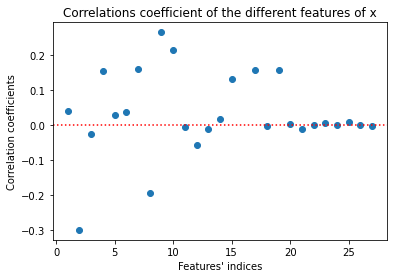

In [145]:
#plot the correlation values betweeny and each feature against the ids of the features
def corrplot(ind, corr):
    plt.scatter(ind, corr, )
    plt.axhline(0, c='r', ls=':')
    plt.title("Correlations coefficient of the different features of x")
    plt.ylabel("Correlation coefficients")
    plt.xlabel("Features' indices")
    plt.savefig('Corrplot.png', dpi=300, bbox_inches='tight')

#compute the correlation coeffincients between y and each of the features of x
corr0 = []
corr1 = []
corr2 = []
corr3 = []
for i in range(len(tx0[1])):
    feat0 = extract(tx0,i)
    corr0.append(np.corrcoef(y0,feat0)[0,1])
for i in range(len(tx1[1])):
    feat1 = extract(tx1,i)
    corr1.append(np.corrcoef(y1,feat1)[0,1])
for i in range(len(tx2[1])):
    feat2 = extract(tx2,i)
    corr2.append(np.corrcoef(y2,feat2)[0,1])
for i in range(len(tx3[1])):
    feat3 = extract(tx3,i)
    corr3.append(np.corrcoef(y3,feat3)[0,1])

#get an array corresponding to the indices of each feature
def listFrom1toN(n):
    return list(range(0,n))
ind0 = listFrom1toN(len(tx0[1]))
ind1 = listFrom1toN(len(tx1[1]))
ind2 = listFrom1toN(len(tx2[1]))
ind3 = listFrom1toN(len(tx3[1]))
#print(ind)

#corrplot(ind0, corr0)
#corrplot(ind1, corr1)
print(ind1)
print(ind2)
print(ind3)
#corrplot(ind2, corr2)
#corrplot(ind3, corr3)


In [ ]:
#d'apres le graph 0: 2,5,7,8,9,10,14,15
#d'apres le graph 1: 2,4,7,8,9,10,15,16,18
#d'apres le graph 2: 2,4,5,6,7,9,10,11,12,13,14,21,23,25
#d'apres le graph 3: 2,4,5,6,7,11,12,13,14,18